# Genre classification
* In this notebook we will perform a **classification** task. Specifically, **given the plot of a movie we aim to predict its genre**. Specifically, we will focus on two movie genres, **drama** and **comedy** (that were by far the two most frequent genres appearing in the dataset).
* The data were obtained by the [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots) dataset, that  contains descriptions of 34,886 movies from around the world, scraped from Wikipedia.

## Import packages
* To begin with, we will import the packages and modules, that we will use in the following segments of this notebook:
    * [pandas](https://pandas.pydata.org/)
    * [NumPy](https://numpy.org/)
    * [pickle](https://docs.python.org/3/library/pickle.html)
    * [SciPy](https://scipy.org/)
    * [seaborn](https://seaborn.pydata.org/)
    * [re](https://docs.python.org/3/library/re.html)
    * [nltk](https://www.nltk.org/)
    * [spaCy](https://spacy.io/)
    * [scikit-learn](https://scikit-learn.org/stable/)

In [39]:
import pandas as pd
import numpy as np
import pickle
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import re

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

import spacy

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

## Load the data
* Following, we will load the data that we prepared in the <code>./data_preparation.ipynb</code> notebook.
* These include:
    * The **plots**: will be used as the independent variables of the classification (X)
    * The **genres (encoded)** of each plot: will be used as labels (Y)
    * The **encoding** of the genres
* *Note: the rows that refer to drama and comedy genres were kept for this task.*

In [2]:
X = np.load('./data/classification/plots.npy', allow_pickle=True)
y = np.load('./data/classification/genres_encoded.npy', allow_pickle=True)
with open('./data/classification/genre_encoding.pickle', 'rb') as file:
    label_encoding = pickle.load(file)

* Let's have a quick look at some of the plot-genre pairs

In [3]:
for i in range(5):
    print(('===Plot===\n'
            f'{X[i]}\n'
            f'===> {label_encoding[y[i]]}\n'))

===Plot===
The film is about a family who move to the suburbs, hoping for a quiet life. Things start to go wrong, and the wife gets violent and starts throwing crockery, leading to her arrest.
===> comedy

===Plot===
Before heading out to a baseball game at a nearby ballpark, sports fan Mr. Brown drinks several highball cocktails. He arrives at the ballpark to watch the game, but has become so inebriated that the game appears to him in reverse, with the players running the bases backwards and the baseball flying back into the pitcher's hand. After the game is over, Mr. Brown is escorted home by one of his friends. When they arrive at Brown's house, they encounter his wife who becomes furious with the friend and proceeds to physically assault him, believing he is responsible for her husband's severe intoxication.[1]
===> comedy

===Plot===
The plot is that of a black woman going to the dentist for a toothache and being given laughing gas. On her way walking home, and in other situations

* Here, from the second plot we can see that it is **not always very obvious the genre of the movie**. Given this violent description here, possibly comedy would not be the first genre that would come to someone's mind.
* We can also have a look at the number of records that refer to each genre.
* Let's do that using a barchart.

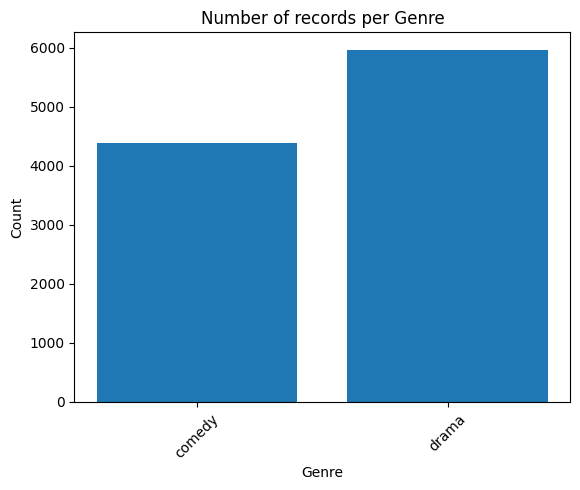

In [4]:
# get the counts for each label
unique_labels, label_counts = np.unique(y, return_counts=True)

#get the genres that correspond the each of the <code>unique_labels</code>
label_genres = np.vectorize(lambda x: label_encoding[x])(unique_labels)

fig, ax = plt.subplots()
ax.bar(label_genres, label_counts)
ax.set_xlabel('Genre')
ax.set_ylabel('Count')
ax.set_title('Number of records per Genre')
plt.xticks(rotation=45) # rotate the x-axis labels for better visibility

plt.show()

* It looks like more *drama* movies are included in the dataset.
* We have to keep this in mind in case we have to handle this imbalance later.

## Helper methods
* Before starting with the modeling, it will be helpful to write some helper methods that we will use throghout this notebook.

In [48]:
def plot_confusion_matrix(confusion_matrix, labels):
    # Normalize the confusion matrix
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    # Set up the plot
    fig, ax = plt.subplots()
    sns.set(font_scale=1.2)

    # Create a heatmap for the confusion matrix
    heatmap = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.2f', xticklabels=labels, yticklabels=labels)

    # Set axis labels and title
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')

    # Rotate the x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

def print_performance_metrics(y_test, y_pred, labels):
    #print accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # plot a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n")
    plot_confusion_matrix(conf_matrix, labels)
    
    # print a classification report that included details about precision, recall, f1-score and support
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

## Simple Text Classification Algorithms
* In this section of the notebook, we will explore the fundamentals of text classification using **simpler machine learning algorithms***.
* These straightforward yet effective models, include:
    * Naive Bayes
    * Logistic Regression
    * Support Vector Machines (SVM)
* We will first execute the **preprocessing steps** required to apply these algorithms.
* These foundational models will provide a solid foundation for later exploring more advanced techniques in text classification.

### Preprocessing
* Before applying machine learning algorithms for text classification, it's essential to **prepare** and **clean** the text data effectively.
* Text preprocessing involves transforming raw text data into a **structured** format that can be used by these simpler machine learning models.

#### 1. Text cleaning
* Text cleaning includes:
  1. Removal of any **special characters**, **symbols**, and **punctuation marks** from the text.
  3. Removal **common stopwords (e.g., "the," "and," "is," "in")** as they often do not carry significant meaning for classification.
  4. Conversion of all words to **lowercase**. This ensures that "word" and "Word" are treated as the same word, reducing feature dimensionality.
  5. Application of **stemming** to the words included in the plots.
* The characters and words mentioned above, typically don't contribute much to the classification task using these simpler algorithms and can be safely removed.

* First, we will create a function that removes special characters, symbols and punctuation marks from the plots' descriptions.
* We will do that using **[regular expressions (regex)](https://en.wikipedia.org/wiki/Regular_expression)**.
* In specific, the regular expression that specifies the characters that we want is <code>[^A-Za-z0-9\s]</code>, which means all the characters that are **not** letters, numbers or whitespace.

In [6]:
def remove_unnecessary_characters(text):
    return re.sub(r'[^A-Za-z0-9\s]', '', text)

* Then we will create a function that removes common stopwords of the English language.
* To do that we will use the stopwords that are included into the [nltk](https://www.nltk.org/) library.
* *Note: in order the do that we have to download the stopwords for english and tokenization packages of ntlk.*

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text) # tokenize the words of the given text
    cleaned_words = [word for word in words if word.lower() not in stop_words] # remove stopwords
    cleaned_text = ' '.join(cleaned_words) # join cleaned words back to text
    return cleaned_text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BT314MC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BT314MC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* Moving on, we will create a function to convert a text to lowercase.

In [8]:
def convert_to_lowercase(text):
    return text.lower()

* Next we will create a function for lemmatization. We will again use the [nltk](https://www.nltk.org/) library for this task, and specifically the <code>WordNetLemmatizer</code>.
* Lemmatization is a **text normalization** technique used in natural language processing (NLP) and information retrieval and aims to reduce words to their dictionary or lemma form.
* Lemmatization helps reduce the dimensionality of text data and improve the performance of various NLP tasks.
* *Note: another very frequently used text normalization tecnhnique is **stemming**, which aims to reduce words to their base or root form by removing suffixes. Here lemmatization was chosen because it is considered more accurate and linguistically grounded.*

In [9]:
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Define a function to convert NLTK part-of-speech tags to WordNet tags,
# it will be used later as an argument of the <code>lemmatize</code> method of the lemmatizer
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if not found
    
def apply_lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text) # tokenize the words of the given text
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words] # Lemmatize each word
    lemmatized_text = ' '.join(lemmatized_words) # join lemmatized words back to text
    return lemmatized_text

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BT314MC\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BT314MC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


* Now that we have created all the functions we need for cleaning we can create a function that applies them all to a given text.

In [10]:
def clean_text(text):
    cleaning_functions = [remove_unnecessary_characters, remove_stopwords, convert_to_lowercase, apply_lemmatization]
    cleaned_text = text
    for cl_func in cleaning_functions:
        cleaned_text = cl_func(cleaned_text)
    return cleaned_text

* Now we can apply this function to our <code>X</code> variable that includes the plots of the movies.
* **The line performing the cleaning is commented out, as it is very time consuming. Its outcome was saved in a file and then read out of it to continue with the rest of the procedure.**

In [11]:
#cleaned_X = np.array([clean_text(plot) for plot in X])
cleaned_X = X = np.load('./data/classification/cleaned_plots.npy', allow_pickle=True)

for i in range(5):
    print(('===Plot===\n'
            f'{cleaned_X[i]}\n'
            f'===> {label_encoding[y[i]]}\n'))

===Plot===
film family move suburb hop quiet life thing start go wrong wife get violent start throw crockery lead arrest
===> comedy

===Plot===
head baseball game nearby ballpark sport fan mr brown drink several highball cocktail arrives ballpark watch game become inebriate game appear reverse player run base backwards baseball fly back pitcher hand game mr brown escort home one friend arrive brown house encounter wife becomes furious friend proceeds physically assault believe responsible husband severe intoxication1
===> comedy

===Plot===
plot black woman go dentist toothache give laugh gas way walk home situation cant stop laugh everyone meet catch laughter include vendor police officer
===> comedy

===Plot===
beautiful summer day father mother take daughter dollie out river mother refuse buy gypsy ware gypsy try rob mother father drive gypsy return camp devise plan return kidnap dollie parent distract rescue crew organize gypsy take dollie camp gag dollie hide barrel rescue party 

* As lemmatization is a time-consuming procedure we will extract the cleaned data.
* *Note: we save the array as of object type because it is more memory efficient in our case because of the varying string length of the plots. More specifically, it is more than 10 times smaller in size this way.*
* **The following line is also commented out in order not to extract the cleaned_plots array every time we execute the code.**

In [12]:
#np.save('./data/classification/cleaned_plots.npy', cleaned_X.astype('O'))

### Train-Test Split
* At this point, and because the following steps require training, it is necessary to **split the data into a train and a test set**.
* This will allow us to evaluate the actual performance of the algorithm.

In [13]:
cleaned_X_train, cleaned_X_test, y_train, y_test = train_test_split(cleaned_X, y, test_size=0.2, random_state=42)
len(cleaned_X_train), len(cleaned_X_test)

(8274, 2069)

### Vectorization
* In this section, we will use techniques to **transform words into numerical features**, providing the foundation for text-based machine learning models.
* Specifically, we will use:
    1. Bag of Words (BoW)
    2. TF-IDF
    3. Word embeddingsels.

#### Bag of Words (BoW)
* The Bag of Words (BoW) model is a **commonly used technique** in natural language processing (NLP) to represent text data as a numerical feature vector. 
* It simplifies the text data by discarding the order and structure of the words and focuses solely on their **frequencies** or **occurrences**.
* An overview of the steps involved in creating a bag-of-words representation is the following:
    1. *Tokenization*: Split the text into individual words or tokens. This step typically involves removing punctuation and splitting the text based on whitespace.
    2. *Vocabulary Creation*: Create a vocabulary by collecting all unique words (tokens) from the text corpus. Each word in the vocabulary becomes a feature.
    3. *Encoding*: Encode each document or text instance into a numerical feature vector. The length of the feature vector is equal to the size of the vocabulary. The value in each feature represents the frequency or occurrence of the corresponding word in the document.
    4. *Vectorization*: Create a matrix representation where each row corresponds to a document, and each column represents a word from the vocabulary. The elements of the matrix are the word frequencies or occurrences.
* In **Python** we can implement the BoW model using the <code>sklearn.feature_extraction.text.CountVectorizer</code> class.
* After the BoW representation has been generated we can use it as **input for various machine learning algorithms**.

In [14]:
bow_vectorizer = CountVectorizer()

* We will use this vectorizer as part of a **Pipeline** in the following section, so we will not train it at this point.
* **The same thing applies for the vectorizers that we will create moving on too.**

#### TF-IDF (Term Frequency-Inverse Document Frequency)
* TF-IDF, short for Term Frequency-Inverse Document Frequency, is a fundamental text analysis technique used in Natural Language Processing (NLP).
* It is designed to measure the **importance of words** within a document or a corpus by considering both their **frequency** within a document and their **rarity** across the entire corpus.
* The TF-IDF formula calculates a weight for each word, where:
    - **Term Frequency (TF)** measures how often a word appears in a document. More frequent words receive higher scores.
    - **Inverse Document Frequency (IDF)** measures how rare a word is across the entire corpus. Words that appear in many documents receive lower scores.
* The TF-IDF score reflects the significance of a word in a specific document relative to its importance in the entire dataset.
* TF-IDF is particularly useful for text-based information retrieval, document ranking, and text classification tasks.
* In practice, libraries like scikit-learn provide the <code>sklearn.feature_extraction.text.TfidfVectorizer</code> class to compute TF-IDF representations from text data.
* Once TF-IDF representations are generated, they can be used as input for machine learning algorithms, especially for tasks that **require understanding the importance of words** within documents.

In [16]:
tf_idf_vectorizer = TfidfVectorizer()

#### Word Embeddings
* Word embeddings are a transformative technique in NLP used to **represent words as dense numerical vectors**.
* Unlike traditional text representations like Bag of Words (BoW), word embeddings capture the **semantic relationships** between words, allowing words with similar meanings to have similar vector representations.
* Word embeddings are often **pre-trained on large text corpora**, learning context-based word representations.
* In our case we will use the [spaCy](https://spacy.io/) library to get the pre-trained embeddings, and we will create a *custom embedding vectorizer* based on these embeddings.

In [35]:
nlp = spacy.load('en_core_web_md')

# Create a custom vectorizer to obtain word vectors for each word in a text
class EmbeddingVectorizer:
    def __init__(self, nlp):
        self.nlp = nlp
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [self.nlp(text).vector for text in X]

embedding_vectorizer = EmbeddingVectorizer(nlp)